# Trabajo de Fin de Grado
## Hodei Zia Lopez

In [2]:
from funcionesMainTFG import *
%matplotlib inline 

Using TensorFlow backend.


## Rutas y Carpetas a ridereccionar los resultados 

In [3]:
# Ruta para guardar las imagenes
RUTA_AUX = 'Datasets/ALL_IDB_Dataset_1/ALL_IDB1/im/'
IMAGE_ID_NAME = os.listdir(RUTA_AUX)
RUTA = RUTA_AUX + IMAGE_ID_NAME[0]
print('RUTA DATASET -> ',RUTA)

# Ruta para guardar el codigo
RUTA_CODE = 'TFG.ipynb'
print('RUTA CODIGO -> ',RUTA_CODE,'\n')

# Variables de guardado en fichero
dia = int(input("Escriba con digitos el dia: "))
mes = int(input("Escriba con digitos el mes: "))
año = int(input("Escriba con digitos el año: "))
prueba = int(input("Escriba con digitos el numero de prueba: "))

# Carpeta en donde vamos a guardar los resultados (codigo, porcentajes e imagenes)
CARPETA = 'Imagenes_Resultados/'
FECHA = str(dia) + "-" + str(mes) + "-" + str(año) + "/"
PRUEBA = 'Prueba ' + str(prueba)
RUTA_PRE_PRUEBA = CARPETA + FECHA
RUTA_PRUEBA = CARPETA + FECHA + PRUEBA + '/'
print('\nRUTA FICHERO CON LOS RESULTADOS -> ',RUTA_PRUEBA)

RUTA DATASET ->  Datasets/ALL_IDB_Dataset_1/ALL_IDB1/im/Im001_1.jpg
RUTA CODIGO ->  TFG.ipynb 

Escriba con digitos el dia: 15
Escriba con digitos el mes: 1
Escriba con digitos el año: 2021
Escriba con digitos el numero de prueba: 1

RUTA FICHERO CON LOS RESULTADOS ->  Imagenes_Resultados/15-1-2021/Prueba 1/


## Creacion de imagenes segmentadas y de imagenes con distintas tonalidades de color

#### El siguiente bloque de codigo genera 108 imagenes con 3 colores aplicando el Algoritmo de K-Means con K=3.

In [7]:
start_time = timeit.default_timer()

for image in range(len(IMAGE_ID_NAME)):
    NAME = IMAGE_ID_NAME[image]
    print(NAME)
    
    img_normal = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    filas,columnas,colores = img_normal.shape
    
    alg = KMeans(n_clusters=3, n_init = 10)
    alg.fit(img_normal.reshape(img_normal.shape[0]* img_normal.shape[1], 3))
    centros = alg.cluster_centers_
    etiquetas = alg.labels_.reshape([filas,columnas])

    imagenfinal2 = imagen_media_color(img_normal,etiquetas,centros)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3/' + NAME.split('.')[0] + '.' + NAME.split('.')[1], imagenfinal2)
    
elapsed = timeit.default_timer() - start_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed)

Im001_1.jpg
Tiempo de ejecucion: 6.1058629000 segundos.


#### El siguiente bloque de codigo genera 108 imagenes con 3 colores aplicando el Algoritmo de K-Means con K=3 solamente para la primera muestra, de donde guardamos las intensidades en los tres espectros de color RGB para calcular la distancia de cada pixel de las demas muestras respecto a las intensidades guardadas, y asi poder tener todas las muestras con las mismas intensidades.

In [8]:
# Importante: No podemos leer la imagen desde la carpeta ya que al perder calidad, se crean mas de 3 colores

start_time = timeit.default_timer()

img_normal = cv2.imread('Datasets/ALL_IDB_Dataset_1/ALL_IDB1/im/Im001_1.jpg')
filas,columnas,colores = img_normal.shape

alg = KMeans(n_clusters=3, n_init = 10)
alg.fit(img_normal.reshape(img_normal.shape[0]* img_normal.shape[1], 3))
centros = alg.cluster_centers_
etiquetas = alg.labels_.reshape([filas,columnas])

imagen_colores = imagen_media_color(img_normal,etiquetas,centros)

aux = np.zeros(shape = (3,3))
count = 0

for i in range(np.shape(imagen_colores)[0]):
    for j in range(np.shape(imagen_colores)[1]):
        if (np.any(aux == imagen_colores[i,j])) == False:
            aux[count] = imagen_colores[i,j] 
            count += 1

print(aux)

# Calculamos la distancia de cada color de pixel respecto a los propuestos para colorear las imagenes
for image in range(len(IMAGE_ID_NAME)):
    NAME = IMAGE_ID_NAME[image]
    print(NAME)
    imagen_test = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    imagen = np.copy(imagen_test)
    
    # Tratamos cada pixel de la imagen
    for i in range(np.shape(imagen)[0]):
        for j in range(np.shape(imagen)[1]):
            color = [[imagen[i,j,0], imagen[i,j,1], imagen[i,j,2]]]
            distancia = np.zeros(3)

            for k in range(3):
                distancia[k] = np.sqrt(np.power(aux[k,0] - color[0][0], 2) + np.power(aux[k,1] - color[0][1], 2) + np.power(aux[k,2] - color[0][2], 2))
            
            imagen[i,j] = aux[np.argmin(distancia)]
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/Imagenes Segmentadas/' + NAME.split('.')[0] + '.' + NAME.split('.')[1], imagen)
    
elapsed = timeit.default_timer() - start_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed)

[[134. 129. 144.]
 [160. 162. 161.]
 [119.  31.  83.]]
Im001_1.jpg
Tiempo de ejecucion: 87.5946016000 segundos.


#### El siguiente bloque de codigo genera 108 imagenes con 3 colores aplicando el Algoritmo de K-Means con K=3. A su vez, sobrepone en las imagenes una mascara de sus leucocitos obtenidos previamente.

In [14]:
start_time = timeit.default_timer()

for image in range(len(IMAGE_ID_NAME)):
    NAME = IMAGE_ID_NAME[image]
    print(NAME)
    
    imagen = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    
    # La pasamos de BGR a HSV en el rango de colores
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    # Aplicamos una mascara para mostrar solamente los colores dentro del rango que queramos
    mask = cv2.inRange(hsv, (60, 60, 0), (150, 255, 255))
    mask = cv2.blur(mask, (3, 3)) 

    # Guardamos una segunda mascara con booleanos
    imask = mask <= 0

    # Creamos una matriz para almacenar los pixeles seleccionados
    nueva_imagen = np.zeros_like(imagen, np.uint8)
    
    # Creamos una matriz para almacenar los pixeles seleccionados
    mascara = np.zeros_like(imagen, np.uint8)

    # Difuminamos la imagen para reducir el ruido
    imagen = cv2.blur(imagen, (3, 3))

    # Asignamos a nuestra nueva imagen los pixeles seleccionados
    nueva_imagen[imask] = imagen[imask]
    
    filas,columnas,colores = nueva_imagen.shape
    
    #cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3 V2/1' + NAME.split('.')[0] + '.' + NAME.split('.')[1], nueva_imagen)

    
    for i in range(filas):
        for j in range(columnas):
            if nueva_imagen[i,j][0] == 0 & nueva_imagen[i,j][1] == 0 & nueva_imagen[i,j][2] == 0:
                nueva_imagen[i,j][0] = 150
                nueva_imagen[i,j][1] = 20
                nueva_imagen[i,j][2] = 75
                mascara[i,j][0] = 150
                mascara[i,j][1] = 20
                mascara[i,j][2] = 75
                
    #cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3 V2/2' + NAME.split('.')[0] + '.' + NAME.split('.')[1], nueva_imagen)
    #cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3 V2/3' + NAME.split('.')[0] + '.' + NAME.split('.')[1], mascara)

    
    alg = KMeans(n_clusters=3, n_init = 10)
    alg.fit(nueva_imagen.reshape(nueva_imagen.shape[0]* nueva_imagen.shape[1], 3))
    centros = alg.cluster_centers_
    etiquetas = alg.labels_.reshape([filas,columnas])

    imagenfinal = imagen_media_color(nueva_imagen,etiquetas,centros)
    

    for i in range(filas):
        for j in range(columnas):
            if mascara[i,j][0] == 150:
                imagenfinal[i,j][0] = 150
                imagenfinal[i,j][1] = 20
                imagenfinal[i,j][2] = 75
    
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3 V2/' + NAME.split('.')[0] + '.' + NAME.split('.')[1], imagenfinal)

elapsed = timeit.default_timer() - start_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed)

Im001_1.jpg
Tiempo de ejecucion: 18.2980758000 segundos.


#### El siguiente bloque de codigo genera 108 imagenes con 3 colores aplicando el Algoritmo de K-Means con K=3. Al igual que antes, aplicamos una mascara con los leucocitos previamente calculada en la imagene original. Tras ello, al tener 3 o 4 intensidades distintas (Si el K-Means no apreciaba leucocitos, una vez superpuestos, tendremos 4 y no 3 intensidades), tintaremos de blanco y rojo los demas objetos de la imagen para poder normalizar las muestras. Tintaremos de un color u otro segun la suma de los tres espectros de color RGB de cada pixel.

In [15]:
start_time = timeit.default_timer()

for image in range(len(IMAGE_ID_NAME)):
    NAME = IMAGE_ID_NAME[image]
    print(NAME)
    
    imagen = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    
    # La pasamos de BGR a HSV en el rango de colores
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    # Aplicamos una mascara para mostrar solamente los colores dentro del rango que queramos
    mask = cv2.inRange(hsv, (60, 60, 0), (150, 255, 255))
    mask = cv2.blur(mask, (3, 3)) 

    # Guardamos una segunda mascara con booleanos
    imask = mask <= 0

    # Creamos una matriz para almacenar los pixeles seleccionados
    nueva_imagen = np.zeros_like(imagen, np.uint8)
    
    # Creamos una matriz para almacenar los pixeles seleccionados
    mascara = np.zeros_like(imagen, np.uint8)

    # Difuminamos la imagen para reducir el ruido
    imagen = cv2.blur(imagen, (3, 3))

    # Asignamos a nuestra nueva imagen los pixeles seleccionados
    nueva_imagen[imask] = imagen[imask]
    
    filas,columnas,colores = nueva_imagen.shape
    
    for i in range(filas):
        for j in range(columnas):
            if nueva_imagen[i,j][0] == 0 & nueva_imagen[i,j][1] == 0 & nueva_imagen[i,j][2] == 0:
                nueva_imagen[i,j][0] = 150
                nueva_imagen[i,j][1] = 20
                nueva_imagen[i,j][2] = 75
                mascara[i,j][0] = 150
                mascara[i,j][1] = 20
                mascara[i,j][2] = 75
                
    # Difuminamos la imagen para reducir el ruido
    nueva_imagen = cv2.blur(nueva_imagen, (10, 10))
                
    alg = KMeans(n_clusters=3, n_init = 10)
    alg.fit(nueva_imagen.reshape(nueva_imagen.shape[0]* nueva_imagen.shape[1], 3))
    centros = alg.cluster_centers_
    etiquetas = alg.labels_.reshape([filas,columnas])

    imagenfinal = imagen_media_color(nueva_imagen,etiquetas,centros)

    aux = np.zeros(shape = (4,3))
    count = 0
    array_colores = np.zeros(3)
    
    for i in range(filas):
        for j in range(columnas):
            if mascara[i,j][0] == 150:
                imagenfinal[i,j][0] = 150
                imagenfinal[i,j][1] = 20
                imagenfinal[i,j][2] = 75
    
    
    for i in range(filas):
        for j in range(columnas):
            if (np.any(aux == imagenfinal[i,j])) == False:
                aux[count] = imagenfinal[i,j] 
                count += 1
    print(aux)
    
    # Es posible que haya cuatro colores, en ese caso, trataremos como globulos rojos a los dos intermedios
    colores_ordenados = np.argsort([int(np.sum(aux[0]))*-1, int(np.sum(aux[1]))*-1, int(np.sum(aux[2]))*-1, int(np.sum(aux[3]))*-1])
    
    # Si hay tres colores 
    if int(aux[3][0]) == 0 and int(aux[3][1]) == 0 and int(aux[3][2]) == 0:
        fondo = aux[colores_ordenados[0]]
        globulos_rojos = aux[colores_ordenados[1]]
    
    # Si hay cuatro colores
    else:
        fondo = aux[colores_ordenados[0]]
        globulos_rojos = aux[colores_ordenados[1]]
        globulos_rojos_2 = aux[colores_ordenados[2]]
    
    print(fondo,globulos_rojos)
    
    # Ponemos el mismo color de fondo
    for i in range(filas):
        for j in range(columnas):
            if int(imagenfinal[i,j][0]) == int(fondo[0]) and int(imagenfinal[i,j][1]) == int(fondo[1]) and int(imagenfinal[i,j][2]) == int(fondo[2]):
                for c in range(3):
                    imagenfinal[i,j][c] = 255
            elif int(imagenfinal[i,j][0]) == int(globulos_rojos_2[0]) and int(imagenfinal[i,j][1]) == int(globulos_rojos_2[1]) and int(imagenfinal[i,j][2]) == int(globulos_rojos_2[2]):
                imagenfinal[i,j][0] = 0
                imagenfinal[i,j][1] = 0
                imagenfinal[i,j][2] = 255
            elif int(imagenfinal[i,j][0]) == int(globulos_rojos[0]) and int(imagenfinal[i,j][1]) == int(globulos_rojos[1]) and int(imagenfinal[i,j][2]) == int(globulos_rojos[2]):
                imagenfinal[i,j][0] = 0
                imagenfinal[i,j][1] = 0
                imagenfinal[i,j][2] = 255
    
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3 V3/' + NAME.split('.')[0] + '.' + NAME.split('.')[1], imagenfinal)


elapsed = timeit.default_timer() - start_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed)

Im001_1.jpg
[[135. 131. 146.]
 [160. 161. 161.]
 [150.  20.  75.]
 [149.  27.  79.]]
[160. 161. 161.] [135. 131. 146.]
Tiempo de ejecucion: 41.5857359000 segundos.


## Conversiones de Color

#### A continuacion, cambiaremos el espacio de color de las 108 imagenes en busca de alguno que nos facilite la posterior segmentacion de los globulos

In [23]:
start_time = timeit.default_timer()

for image in range(len(IMAGE_ID_NAME)):
    NAME = IMAGE_ID_NAME[image]
    print(NAME)
    
    # Imagen Normal (BGR)
    img_normal = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Normal (BGR)/' + NAME, img_normal)
    
    img_normal[:,:,0] = cv2.equalizeHist(img_normal[:,:,0])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Normal (BGR)/' + NAME.split('.')[0] + '_B.' + NAME.split('.')[1], img_normal)
    img_normal = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    img_normal[:,:,1] = cv2.equalizeHist(img_normal[:,:,1])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Normal (BGR)/' + NAME.split('.')[0] + '_G.' + NAME.split('.')[1], img_normal)
    img_normal = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    img_normal[:,:,2] = cv2.equalizeHist(img_normal[:,:,2])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Normal (BGR)/' + NAME.split('.')[0] + '_R.' + NAME.split('.')[1], img_normal)
    
    # Imagen con Histograma Ampliado [0,255]
    img_normal = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    imagen = ampliacion_histograma(img_normal)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Rango Ampliado/' +NAME.split('.')[0] + '_Ampliado.' + NAME.split('.')[1], imagen)
    
    # Imagen YUV
    img_yuv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YUV)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YUV/' + NAME.split('.')[0] + '_YUV.' + NAME.split('.')[1], img_yuv)
    
    img_yuv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YUV/' + NAME.split('.')[0] + '_YUV_B.' + NAME.split('.')[1], img_yuv)
    img_yuv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,1] = cv2.equalizeHist(img_yuv[:,:,1])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YUV/' + NAME.split('.')[0] + '_YUV_G.' + NAME.split('.')[1], img_yuv)
    img_yuv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,2] = cv2.equalizeHist(img_yuv[:,:,2])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YUV/' + NAME.split('.')[0] + '_YUV_R.' + NAME.split('.')[1], img_yuv)
    
    # Imagen HSV
    img_hsv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HSV)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HSV/' + NAME.split('.')[0] + '_HSV.' + NAME.split('.')[1], img_hsv)
    
    img_hsv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HSV)
    img_hsv[:,:,0] = cv2.equalizeHist(img_hsv[:,:,0])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HSV/' + NAME.split('.')[0] + '_HSV_B.' + NAME.split('.')[1], img_hsv)
    img_hsv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HSV)
    img_hsv[:,:,1] = cv2.equalizeHist(img_hsv[:,:,1])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HSV/' + NAME.split('.')[0] + '_HSV_G.' + NAME.split('.')[1], img_hsv)
    img_hsv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HSV)
    img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HSV/' + NAME.split('.')[0] + '_HSV_R.' + NAME.split('.')[1], img_hsv)
    
    # Imagen YCC
    img_ycc = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YCrCb)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YCC/' + NAME.split('.')[0] + '_YCC.' + NAME.split('.')[1], img_ycc)
    
    img_ycc = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YCrCb)
    img_ycc[:,:,0] = cv2.equalizeHist(img_ycc[:,:,0])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YCC/' + NAME.split('.')[0] + '_YCC_B.' + NAME.split('.')[1], img_ycc)
    img_ycc = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YCrCb)
    img_ycc[:,:,1] = cv2.equalizeHist(img_ycc[:,:,1])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YCC/' + NAME.split('.')[0] + '_YCC_G.' + NAME.split('.')[1], img_ycc)
    img_ycc = cv2.cvtColor(img_normal, cv2.COLOR_BGR2YCrCb)
    img_ycc[:,:,2] = cv2.equalizeHist(img_ycc[:,:,2])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/YCC/' + NAME.split('.')[0] + '_YCC_R.' + NAME.split('.')[1], img_ycc)
    
    # Imagen HLS
    img_hls = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HLS)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HLS/' + NAME.split('.')[0] + '_HLS.' + NAME.split('.')[1], img_hls)
    
    img_hls = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HLS)
    img_hls[:,:,0] = cv2.equalizeHist(img_hls[:,:,0])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HLS/' + NAME.split('.')[0] + '_HLS_B.' + NAME.split('.')[1], img_hls)
    img_hls = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HLS)
    img_hls[:,:,1] = cv2.equalizeHist(img_hls[:,:,1])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HLS/' + NAME.split('.')[0] + '_HLS_G.' + NAME.split('.')[1], img_hls)
    img_hls = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HLS)
    img_hls[:,:,2] = cv2.equalizeHist(img_hls[:,:,2])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/HLS/' + NAME.split('.')[0] + '_HLS_R.' + NAME.split('.')[1], img_hls)
    
    # Imagen CIE Lab
    img_lab = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Lab)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Lab/' + NAME.split('.')[0] + '_CIE_Lab.' + NAME.split('.')[1], img_lab)
    
    img_lab = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Lab)
    img_lab[:,:,0] = cv2.equalizeHist(img_lab[:,:,0])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Lab/' + NAME.split('.')[0] + '_CIE_Lab_B.' + NAME.split('.')[1], img_lab)
    img_lab = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Lab)
    img_lab[:,:,1] = cv2.equalizeHist(img_lab[:,:,1])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Lab/' + NAME.split('.')[0] + '_CIE_Lab_G.' + NAME.split('.')[1], img_lab)
    img_lab = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Lab)
    img_lab[:,:,2] = cv2.equalizeHist(img_lab[:,:,2])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Lab/' + NAME.split('.')[0] + '_CIE_Lab_R.' + NAME.split('.')[1], img_lab)
   
    # Imagen CIE Luv
    img_luv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Luv)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Luv/' + NAME.split('.')[0] + '_CIE_Luv.' + NAME.split('.')[1], img_luv)
    
    img_luv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Luv)
    img_luv[:,:,0] = cv2.equalizeHist(img_luv[:,:,0])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Luv/' + NAME.split('.')[0] + '_CIE_Luv_B.' + NAME.split('.')[1], img_luv)
    img_luv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Luv)
    img_luv[:,:,1] = cv2.equalizeHist(img_luv[:,:,1])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Luv/' + NAME.split('.')[0] + '_CIE_Luv_G.' + NAME.split('.')[1], img_luv)
    img_luv = cv2.cvtColor(img_normal, cv2.COLOR_BGR2Luv)
    img_luv[:,:,2] = cv2.equalizeHist(img_luv[:,:,2])
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/CIE_Luv/' + NAME.split('.')[0] + '_CIE_Luv_R.' + NAME.split('.')[1], img_luv)
    
    # Imagen Ecualizada a Grises
    img = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image], cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Ecualizada/' + NAME.split('.')[0] + '_Ecualized.' + NAME.split('.')[1], img)
    
    # Imagen Ecualizada a Color
    img = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image], cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)
    cv2.imwrite('Imagenes_Resultados/Imagenes_Color_Conversions/Ecualizada/' + NAME.split('.')[0] + '_Ecualized_Color.' + NAME.split('.')[1], img)
    
    # Imagen CMYK
    img = Image.open(RUTA_AUX + IMAGE_ID_NAME[image]).convert('CMYK')
    img.save('Imagenes_Resultados/Imagenes_Color_Conversions/CMYK/' + NAME.split('.')[0] + '_CMYK.' + NAME.split('.')[1])
    
elapsed = timeit.default_timer() - start_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed)

Im001_1.jpg
Tiempo de ejecucion: 2.4338472000 segundos.


## Programa Principal
#### Con este programa, guardamos tanto las imagenes como el codigo como un csv con los datos de las variables de cada muestra
#### Estamos teniendo en cuenta 17 parametros obtenidos de la imagen original, la imagen obtenida tras K-Means de K = 3, y la imagen normalizada en rojo, blanco y morado

In [4]:
# PROGRAMA PRINCIPAL

start_time = timeit.default_timer()

# Creamos la carpeta con la fecha introducida
try:
    os.mkdir(RUTA_PRE_PRUEBA)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

# Creamos la carpeta de pruebas 
try:
    os.mkdir(RUTA_PRUEBA)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

# Guardamos el codigo en la carpeta 1 y en la carpeta 2
shutil.copy(RUTA_CODE, RUTA_PRUEBA + PRUEBA +  '_' + RUTA_CODE)

# Creamos los vectores de conteo
CONTEO_G = np.zeros(108)
ARRAY_PORCENTAJES = np.zeros(108)
ARRAY_MORADOS = np.zeros(108)

# Creamos el fichero CSV
f = open(RUTA_PRUEBA + '/data_tfg.csv','w')
writer = csv.writer(f)
writer.writerow(['Porcentaje', 'Leucocitos', 'HistMax1', 'PixelesMax1', 'HistMax2', 'PixelesMax2', 'DiferenciaPicos', 'PixelesSegMax1', 'PixelesSegMax2', 'PixelesSegMax3', 'MoradosEnCluster', 'Blancos', 'Rojos', 'Morados', 'Porcentaje_Blancos', 'Porcentaje_Rojos', 'Porcentaje_Morados','Clase'])
csv_data = []

# Comenzamos con el programa
for image in range(len(IMAGE_ID_NAME)):
    
    # Imprimimos que imagen estamos tratando
    print('\n', image + 1, '-', IMAGE_ID_NAME[image])
          
    # Leemos la imagen original
    imagen = cv2.imread(RUTA_AUX + IMAGE_ID_NAME[image])
    
    # Leemos la imagen segmentada en Rojo (0,0,255), Blanco (255,255,255) y Morado (150,20,75)
    imagen_cluster_tratada = cv2.imread('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3 V3/' + IMAGE_ID_NAME[image])
    
    # Leemos la imagen segmentada del Cluster K = 3
    imagen_cluster = cv2.imread('Imagenes_Resultados/Imagenes_Color_Conversions/Imagenes K-Means/K = 3/' + IMAGE_ID_NAME[image])
    
# TRATAMOS LA IMAGEN_CLUSTER DE K-MEANS CON K = 3
    
    # La pasamos de BGR a HSV en el rango de colores
    hsv_cluster = cv2.cvtColor(imagen_cluster, cv2.COLOR_BGR2HSV)

    # Aplicamos una mascara para mostrar solamente los colores dentro del rango que queramos
    mask_cluster = cv2.inRange(hsv_cluster, (60, 60, 0), (150, 255, 255))

    # Guardamos una segunda mascara con booleanos
    imask_cluster = mask_cluster > 0

    # Creamos una matriz para almacenar los pixeles seleccionados
    nueva_imagen_cluster = np.zeros_like(imagen_cluster, np.uint8)

    # Asignamos a nuestra nueva imagen los pixeles seleccionados
    nueva_imagen_cluster[imask_cluster] = imagen_cluster[imask_cluster]

    # Sacamos el histograma de la imagen        
    h_cluster = cv2.calcHist([nueva_imagen_cluster],[0],None,[256],[0,256]).flatten()

    # Calculamos el porcentaje de pixeles no blancos en la imagen
    porcentaje_no_negros_cluster = 1 - (h_cluster[0] / np.sum(h_cluster))

    # Normalizamos los porcentajes dentro del rango 0-100
    porcentaje_normalizado_cluster = ((porcentaje_no_negros_cluster - 0) / (100 - 0)) 
    
    print(porcentaje_normalizado_cluster)
    
    if porcentaje_normalizado_cluster == 0:
        ARRAY_MORADOS[image] = 1
    
# TRATAMOS LA IMAGEN_CLUSTER_TRATADA EN BLANCO, ROJO Y MORADO TRAS UN K-MEANS DE K = 3   
    
    # Llamamos a la funcion de calculo de pixeles en la imagen segregada
    xMaxSeg, xMaxSeg2, difSeg, pixelesSeg1, pixelesSeg2 = min_entre_max(imagen_cluster_tratada)
    
    # Sacamos el numero de pixeles restantes
    filas, columnas, colores = np.shape(imagen_cluster)
    pixelesSeg3 = filas*columnas - (pixelesSeg1 + pixelesSeg2)
    
    # Llamamos a la funcion de calculo de pixeles y porcentajes en la imagen tratada a color
    blanco, rojo, morado, porcentaje_blanco, porcentaje_rojo, porcentaje_morado = pixeles_porcentajes_RGB(IMAGE_ID_NAME[image])
    
# TRATAMOS LA IMAGEN ORIGINAL    
    
    # Llamamos a la funcion de calculo de picos del histograma con la imagen tratada
    xMax, xMax2, dif, pixeles1, pixeles2 = min_entre_max(imagen)
    
    # Guardamos el identificador de la imagen correspondiente
    NAME = IMAGE_ID_NAME[image]
    
    # Ampliamos el rango dinamico del histograma
    imagen = ampliacion_histograma(imagen)

    # La pasamos de BGR a HSV en el rango de colores
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    # Aplicamos una mascara para mostrar solamente los colores dentro del rango que queramos
    mask = cv2.inRange(hsv, (60, 60, 0), (150, 255, 255))
    mask = cv2.blur(mask, (3, 3)) 
    
    # Guardamos una segunda mascara con booleanos
    imask = mask > 0
    
    # Creamos una matriz para almacenar los pixeles seleccionados
    nueva_imagen = np.zeros_like(imagen, np.uint8)
    
    # Difuminamos la imagen para reducir el ruido
    imagen = cv2.blur(imagen, (3, 3))
    
    # Asignamos a nuestra nueva imagen los pixeles seleccionados
    nueva_imagen[imask] = imagen[imask]
    
    # Sacamos el histograma de la imagen        
    h = cv2.calcHist([nueva_imagen],[0],None,[256],[0,256]).flatten()
    
    # Calculamos el porcentaje de pixeles no negros en la imagen
    porcentaje_no_negros = 1 - (h[0] / np.sum(h))
    
    # Normalizamos los porcentajes dentro del rango 0-100
    porcentaje_normalizado = (porcentaje_no_negros - 0) / (100 - 0)
    
    # Transformamos la imagen a grises
    gray = cv2.cvtColor(nueva_imagen, cv2.COLOR_BGR2GRAY) 

    # Difuminamos la imagen para reducir el ruido 
    gray_blurred = cv2.blur(gray, (3, 3)) 
    
    # Aplicamos la Transformada de Hough sobre la imagen difuminada 
    detected_circles = cv2.HoughCircles(gray_blurred,  
                       cv2.HOUGH_GRADIENT, 1, 95, param1 = 70, 
                   param2 = 20, minRadius = 40, maxRadius = 85)
    
    # Creamos una variable para guardar la cantidad de circulos en la imagen
    circle_count_G = 0

    # En caso de que detecte un circulo, que lo muestre
    if detected_circles is not None: 

        # Transformamos los parametros del circulo a enteros
        detected_circles = np.uint16(np.around(detected_circles)) 

        for pt in detected_circles[0, :]: 
            a, b, r = pt[0], pt[1], pt[2] 

            # Pintamos la circunferencia del circulo de verde
            cv2.circle(nueva_imagen, (a, b), r, (0, 255, 0), 5) 

            # Marcamos el centroide de la circunferencia en negro
            cv2.circle(nueva_imagen, (a, b), 1, (0, 0, 0), 3) 
            
            # Contamos el circulo
            circle_count_G += 1

    # Guardamos la imagen creada en la ruta especificada        
    cv2.imwrite(RUTA_PRUEBA + NAME, nueva_imagen)
    
    # Normalizamos los porcentajes nuevamente para que la diferencia entre los valores puedan apreciarse mejor
    ARRAY_PORCENTAJES[image] = porcentaje_normalizado * 10000

    # Guardamos la cantidad de circulos de la imagen dentro del array
    CONTEO_G[image] = circle_count_G
    
    # Guardamos la cantidad total de circulos detectados en todas las muestras
    GREEN = np.sum(CONTEO_G)
    
    # Guardamos los datos de la imagen en la lista para su conversion en CSV
    csv_data.append([ARRAY_PORCENTAJES[image], CONTEO_G[image],xMax, pixeles1, xMax2, pixeles2, dif, pixelesSeg1, pixelesSeg2, pixelesSeg3, ARRAY_MORADOS[image], blanco, rojo, morado, porcentaje_blanco, porcentaje_rojo, porcentaje_morado, int(NAME.split('.')[0].split('_')[1])])
writer.writerows(csv_data)
f.close()

print('MEDIA DE VERDES:', GREEN/108)

data = pd.read_csv(RUTA_PRUEBA + '/data_tfg.csv')    #Cargamos los datos en Data
data  

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)


 1 - Im001_1.jpg
0.0007083296775817871

 2 - Im002_1.jpg
0.000899498462677002

 3 - Im003_1.jpg
0.0006194663047790527

 4 - Im004_1.jpg
0.0005311793088912963

 5 - Im005_1.jpg
0.0013692778348922728

 6 - Im006_1.jpg
0.0010123801231384276

 7 - Im007_1.jpg
0.000489044189453125

 8 - Im008_1.jpg
0.000999075174331665

 9 - Im009_1.jpg
0.0005129510164260864

 10 - Im010_1.jpg
0.0008191448450088501

 11 - Im011_1.jpg
0.0008612364530563354

 12 - Im012_1.jpg
0.000655490756034851

 13 - Im013_1.jpg
0.0004591643810272217

 14 - Im014_1.jpg
0.0004986345767974854

 15 - Im015_1.jpg
0.0008562707901000977

 16 - Im016_1.jpg
0.0009502708911895752

 17 - Im017_1.jpg
0.00013947784900665284

 18 - Im018_1.jpg
0.000753445029258728

 19 - Im019_1.jpg
0.0009735888242721558

 20 - Im020_1.jpg
7.289886474609375e-05

 21 - Im021_1.jpg
0.0001075911521911621

 22 - Im022_1.jpg
0.00017901241779327392

 23 - Im023_1.jpg
0.00024282515048980712

 24 - Im024_1.jpg
0.00016171097755432129

 25 - Im025_1.jpg
0.00011

## Rendimiento con umbrales manuales
#### En este bloque de codigo, intentaremos ver que porcentajes de acierto podemos obtener a simple vista sin aplicar nada mas que operaciones aritmeticas. Para ello, haremos uso de 6 metodos que pretenden crear un umbral con el que separar en dos clases las muestras en base a distintos parametros

In [6]:
# AREA DE RESULTADOS

start_time = timeit.default_timer()

# Clase Leucemia
LEU = np.sort(np.hstack((ARRAY_PORCENTAJES[0:33], ARRAY_PORCENTAJES[47:63])))  # 49
LEU_CIRCLE = np.sort(np.hstack((CONTEO_G[0:33], CONTEO_G[47:63])))  

# Clase No-Leucemia
NOLEU = np.sort(np.hstack((ARRAY_PORCENTAJES[33:47], ARRAY_PORCENTAJES[63:108]))) # 59
NOLEU_CIRCLE = np.sort(np.hstack((CONTEO_G[33:47], CONTEO_G[63:108]))) 


# Metodo 1 - Frontera de Decision como porcentaje mas pequeño de las muestras de Leucemia

minimoLEU = np.min(LEU)
cont = 0

for i in NOLEU:
    if i > minimoLEU:
        cont += 1
        
porcentaje_acierto_1 = ((len(LEU) + len(NOLEU) - cont) / (len(LEU) + len(NOLEU))) * 100
print('\nPorcentaje de Acierto para metodo 1:', porcentaje_acierto_1)
        
# Metodo 2 - Frontera de Decision como porcentaje mas grande de las muestras de No-Leucemia
    
maximoNOLEU = np.max(NOLEU)
cont = 0

for i in LEU:
    if i < maximoNOLEU:
        cont += 1
        
porcentaje_acierto_2 = ((len(LEU) + len(NOLEU) - cont) / (len(LEU) + len(NOLEU))) * 100
print('\nPorcentaje de Acierto para metodo 2:', porcentaje_acierto_2)

        
# Metodo 3 - Frontera de Decision como numero de leucocitos mas pequeño de las muestras de Leucemia
    
minimoLEU_CIRCLE = np.min(LEU_CIRCLE)
cont = 0

for i in NOLEU_CIRCLE:
    if i > minimoLEU_CIRCLE:
        cont += 1
    
porcentaje_acierto_3 = ((len(LEU_CIRCLE) + len(NOLEU_CIRCLE) - cont) / (len(LEU_CIRCLE) + len(NOLEU_CIRCLE))) * 100
print('\nPorcentaje de Acierto para metodo 3:', porcentaje_acierto_3)

        
# Metodo 4 - Frontera de Decision como numero de leucocitos mas grande de las muestras de No-Leucemia
    
maximoNOLEU_CIRCLE = np.max(NOLEU_CIRCLE)
cont = 0

for i in LEU_CIRCLE:
    if i < maximoNOLEU_CIRCLE:
        cont += 1
        
porcentaje_acierto_4 = ((len(LEU_CIRCLE) + len(NOLEU_CIRCLE) - cont) / (len(LEU_CIRCLE) + len(NOLEU_CIRCLE))) * 100
print('\nPorcentaje de Acierto para metodo 4:', porcentaje_acierto_4)


# Metodo 5 - Frontera de Decision como combinacion entre ambos parametros

LEU_COMB = np.zeros(49)
NOLEU_COMB = np.zeros(59)

LEU_COMB[0:33] = ARRAY_PORCENTAJES[0:33] * CONTEO_G[0:33]
LEU_COMB[33:49] = ARRAY_PORCENTAJES[47:63] * CONTEO_G[47:63]

NOLEU_COMB[0:14] = ARRAY_PORCENTAJES[33:47] * CONTEO_G[33:47]
NOLEU_COMB[14:59] = ARRAY_PORCENTAJES[63:108] * CONTEO_G[63:108]

LEU_COMB = np.sort(LEU_COMB)
NOLEU_COMB = np.sort(NOLEU_COMB)

maximoNOLEU_COMB = np.max(NOLEU_COMB)
cont = 0

for i in LEU_COMB:
    if i < maximoNOLEU_COMB:
        cont += 1
        
porcentaje_acierto_5 = ((len(LEU_COMB) + len(NOLEU_COMB) - cont) / (len(LEU_COMB) + len(NOLEU_COMB))) * 100
print('\nPorcentaje de Acierto para metodo 5:', porcentaje_acierto_5)

minimoLEU_COMB = np.min(LEU_COMB)
cont = 0

for i in NOLEU_COMB:
    if i > minimoLEU_COMB:
        cont += 1
        
porcentaje_acierto_6 = ((len(LEU_COMB) + len(NOLEU_COMB) - cont) / (len(LEU_COMB) + len(NOLEU_COMB))) * 100
print('\nPorcentaje de Acierto para metodo 6:', porcentaje_acierto_6)


print('\n//////////////////////////////LEUCEMIA://////////////////////////////\n\nPORCENTAJES\n', LEU, '\n\nLEUCOCITOS\n', LEU_CIRCLE, '\n\nCOMBINACION\n', LEU_COMB)
print('\n----------------------------------------------------------------------------')
print('\n//////////////////////////////NO LEUCEMIA://////////////////////////////\n\nPORCENTAJES\n', NOLEU, '\n\nLEUCOCITOS\n', NOLEU_CIRCLE, '\n\nCOMBINACION\n', NOLEU_COMB)
print('\n----------------------------------------------------------------------------')


# Guardamos los porcentajes para su posterior estudio

f = open ('Porcentajes.txt','w')
f.write('Metodo 1 - Frontera de Decision como porcentaje mas pequeño de las muestras de Leucemia\n')
f.write(str(porcentaje_acierto_1))
f.write('\n\nMetodo 2 - Frontera de Decision como porcentaje mas grande de las muestras de No-Leucemia\n')
f.write(str(porcentaje_acierto_2))
f.write('\n\nMetodo 3 - Frontera de Decision como numero de leucocitos mas pequeño de las muestras de Leucemia\n')
f.write(str(porcentaje_acierto_3))
f.write('\n\nMetodo 4 - Frontera de Decision como numero de leucocitos mas grande de las muestras de No-Leucemia\n')
f.write(str(porcentaje_acierto_4))
f.write('\n\nMetodo 5 - Frontera de Decision como combinacion entre ambos parametros con umbral pequeño de las muestras de Leucemia\n')
f.write(str(porcentaje_acierto_5))
f.write('\n\nMetodo 6 - Frontera de Decision como combinacion entre ambos parametros con umbral mas grande de las muestras de No-Leucemia\n')
f.write(str(porcentaje_acierto_6))
f.write('\n\n')
f.close()

shutil.move("Porcentajes.txt", RUTA_PRUEBA + "/Porcentajes.txt")

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)


Porcentaje de Acierto para metodo 1: 92.5925925925926

Porcentaje de Acierto para metodo 2: 96.29629629629629

Porcentaje de Acierto para metodo 3: 91.66666666666666

Porcentaje de Acierto para metodo 4: 90.74074074074075

Porcentaje de Acierto para metodo 5: 91.66666666666666

Porcentaje de Acierto para metodo 6: 90.74074074074075

//////////////////////////////LEUCEMIA://////////////////////////////

PORCENTAJES
 [ 0.75930357  0.97458959  1.08274221  1.40737891  1.52454376  1.55528188
  1.60220861  1.70208216  2.04443336  2.09627151  2.4902463   2.52402425
  2.56595016  2.68469453  2.91906595  3.78655791  4.50739861  4.72759008
  5.109936    5.19589186  5.51836491  5.53432107  5.81148863  5.89035153
  6.23399019  6.33057356  6.63513541  6.88639283  6.9832027   7.48329759
  7.53902197  8.02398324  8.11342001  8.84616971  8.91571045  9.07487273
  9.3765378   9.76574421 10.10868549 10.20590663 10.27392745 10.28197408
 11.06106639 11.11866832 11.68518662 11.80226803 12.15209365 13.00989

## Fase de Clasificacion
#### A continuacion, calcularemos para cada clasificador, el rendimiento que obtiene en train y test tras utilizar todas las variables

In [7]:
start_time = timeit.default_timer()

# Leemos las variables de nuestro CSV
X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')

# KNN
knn = neighbors.KNeighborsClassifier()
resultados(knn,X,y)
print('\n')

# Arboles de Decision
arbol = tree.DecisionTreeClassifier(random_state = 12)
resultados(arbol,X,y)
print('\n') 

# Random Forest
random = ensemble.RandomForestClassifier(random_state = 12)
resultados(random,X,y)
print('\n')  

# Regresion Logistica
logistic = linear_model.LogisticRegression()
resultados(logistic,X,y)
print('\n')  

# SVM
SVM = svm.SVC()
resultados(SVM,X,y)
print('\n')  

# Redes Neuronales
red_neuronal = neural_network.MLPClassifier(max_iter = 300)
resultados(red_neuronal,X,y)
print('\n\n')     

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

El rendimiento en entrenamiento usando KNeighborsClassifier con todas las variables es el 100.0%
El rendimiento en test usando KNeighborsClassifier con todas las variables es el 96.96969696969697% 
FScore de 95.84026622296173%


El rendimiento en entrenamiento usando DecisionTreeClassifier con todas las variables es el 100.0%
El rendimiento en test usando DecisionTreeClassifier con todas las variables es el 100.0% 
FScore de 100.0%


El rendimiento en entrenamiento usando RandomForestClassifier con todas las variables es el 100.0%
El rendimiento en test usando RandomForestClassifier con todas las variables es el 96.96969696969697% 
FScore de 95.84026622296173%


El rendimiento en entrenamiento usando LogisticRegression con todas las variables es el 100.0%
El rendimiento en test usando LogisticRegression con todas las variables es el 100.0% 
FScore de 100.0%


El rendimiento en entrenamiento usando SVC con todas las variables es el 84.0%
El rendimiento en test usando SVC con todas las v

#### Ahora, calcularemos el rendimiento para cada clasificador utilizando los valores de los parametros que nos den el mejor resultado. Esto lo haremos para los datos sin normalizar y para los datos normalizados de dos formas distintas

In [8]:
start_time = timeit.default_timer()

# Leemos las variables de nuestro CSV
X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')

# Ejecutamos la funcion que nos hace el Grid Search para obtener los mejores parametros
resultados_aprendizaje_normalizado(X,y,grid=True,verbose=True)

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

1- Metodo de normalizacion: Sin normalizar

     -Clasificador: KNeighborsClassifier 

      knn {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'} 99.0909090909091%


     -Clasificador: DecisionTreeClassifier 

      arbol_decision {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2} 99.0909090909091%


     -Clasificador: RandomForestClassifier 

      random_forest {'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 10} 100.0%


     -Clasificador: LogisticRegression 

      logistica {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'} 99.0909090909091%


     -Clasificador: SVC 

      svm {'C': 30, 'gamma': 'scale'} 99.0909090909091%


     -Clasificador: MLPClassifier 

      red_neuronal {'activation': 'tanh', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'shuffle': False, 'solver': 'lbfgs'} 100.0%

2- Metodo de normalizacion: MinMaxScaler()

     -Clasificador: KNeighborsClassifier 

      knn {'n_neighbors': 1

## Fase de Interpretabilidad de los modelos

#### De las 17 variables que tenemos, vamos a hacer un estudio para determinar la importancia de cada una

In [9]:
start_time = timeit.default_timer()

# Creamos la carpeta en donde meter las imagenes de la interpretabilidad
try:
    os.mkdir(RUTA_PRUEBA + 'Imagenes Interpretabilidad')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
        
# Metemos los feature_names
feature_names = ['Porcentaje', 'Leucocitos', 'HistMax1', 'PixelesMax1', 'HistMax2', 'PixelesMax2', 'DiferenciaPicos', 'PixelesSegMax1', 'PixelesSegMax2', 'PixelesSegMax3', 'MoradosEnCluster', 'Blancos', 'Rojos', 'Morados', 'Porcentaje_Blancos', 'Porcentaje_Rojos', 'Porcentaje_Morados']
caracteristicas = len(feature_names)
caracteriticas_ordenadas = np.arange(caracteristicas)

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

Elapsed time: 0.0006038000 seconds.


#### A continuacion, calcularemos los porcentajes de acierto para toda combinacion de cantidad de hiper parametros en base a distintas medidas de calidad

In [10]:
start_time = timeit.default_timer()

# Listas para almacenar los resultados de accuracy en train y test
listaAccTrain = []
listaAccTest = []
variables = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
medidas_de_calidad = [feature_selection.chi2, feature_selection.f_classif, feature_selection.f_regression]

X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')

X_norm_std = normalizarDatos(X)

# Separamos en Train y Test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7, random_state = 1)

for i in medidas_de_calidad:
    print('Para la medida de calidad',str(i),'\n')

    for numVar in variables:
        # Se llama al constructor que realiza la selección de las k mejores variables con los parámetros apropiados
        tecnicaSeleccion = feature_selection.SelectKBest(score_func=i, k=numVar)

        # Llamada a la función que aprende los parámetros de la selección de variables a partir de los datos de entrenamiento
        tecnicaSeleccion =  tecnicaSeleccion.fit(X_train,y_train)

        # Llamada a la función que transforma los datos de entrenamiento: realiza la selección de variables
        X_train_seleccion = tecnicaSeleccion.transform(X_train)

        # Llamada a la función que transforma los datos de test: realiza la selección de variables
        X_test_seleccion =  tecnicaSeleccion.transform(X_test)

        # Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
        knn =  neighbors.KNeighborsClassifier()

        # Llamada a la función que realiza el aprendizaje del clasificador
        knn =  knn.fit(X_train_seleccion, y_train)

        # Llamada a la función que realiza la predicción de los datos de entrenamiento
        prediccionTrain =  knn.predict(X_train_seleccion)

        # Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento
        accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100

        # Se añade el resultado a la lista de resultados de train
        listaAccTrain.append(accTrain)

        print('     Seleccionando las {} mejores variables se obtiene un accuracy del {}% en entrenamiento'.format(numVar, accTrain))

        # Llamada a la función que realiza la predicción de los datos de test
        prediccionTest =  knn.predict(X_test_seleccion)

        # Llamada a la función que calcula el porcentaje de acierto para los datos de test
        accTest =  metrics.accuracy_score(y_test,prediccionTest)*100

        # Se añade el resultado a la lista de resultados de test
        listaAccTest.append(accTest)

        print('     Seleccionando las {} mejores variables se obtiene un accuracy del {}% en test\n'.format(numVar, accTest))
        
elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

Para la medida de calidad <function chi2 at 0x000001751318A048> 

     Seleccionando las 1 mejores variables se obtiene un accuracy del 93.33333333333333% en entrenamiento
     Seleccionando las 1 mejores variables se obtiene un accuracy del 90.9090909090909% en test

     Seleccionando las 2 mejores variables se obtiene un accuracy del 96.0% en entrenamiento
     Seleccionando las 2 mejores variables se obtiene un accuracy del 93.93939393939394% en test

     Seleccionando las 3 mejores variables se obtiene un accuracy del 96.0% en entrenamiento
     Seleccionando las 3 mejores variables se obtiene un accuracy del 93.93939393939394% en test

     Seleccionando las 4 mejores variables se obtiene un accuracy del 97.33333333333334% en entrenamiento
     Seleccionando las 4 mejores variables se obtiene un accuracy del 90.9090909090909% en test

     Seleccionando las 5 mejores variables se obtiene un accuracy del 97.33333333333334% en entrenamiento
     Seleccionando las 5 mejores variabl

#### En el siguiente bloque de codigo, visualizaremos los porcentajes de acierto de train y test para todas las combinaciones de cantidades de hiper parametros. Para ello usaremos un PCA que mantenga el numero de componentes dada

Con 1 numero de componentes se obtiene un accuracy del 97.33333333333334% en train y del 81.81818181818183% en test
Con 2 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 3 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 4 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 5 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 6 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 7 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 8 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 9 numero de componentes se obtiene un accuracy del 98.66666666666667% en train y del 100.0% en test
Con 10 numero de componentes se obtiene un accuracy 

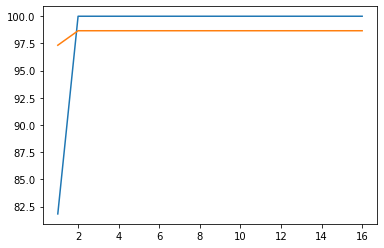

In [19]:
start_time = timeit.default_timer()

listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
listaNumPCs = [] # lista para almancenar el número de compomentes principales de cada opción
porcentajes =[0.8, 0.85, 0.9, 0.95]
numero_de_componentes_max = X_train.shape[1]

for numero_de_componentes in range(1,numero_de_componentes_max):
    pca = PCA(n_components = numero_de_componentes)
    pca = pca.fit(X_train, y_train)

    X_trainTrans = pca.transform(X_train)
    X_testTrans = pca.transform(X_test)

    knn = neighbors.KNeighborsClassifier()
    knn.fit(X_trainTrans, y_train)

    prediccionTrain = knn.predict(X_trainTrans)
    prediccionTest = knn.predict(X_testTrans)

    accTrain = metrics.accuracy_score(y_train, prediccionTrain)*100
    accTest = metrics.accuracy_score(y_test, prediccionTest)*100
    
    listaAccTrain.append(accTrain)
    listaAccTest.append(accTest)
    listaNumPCs.append(pca.n_components_)
    
    print('Con {} numero de componentes se obtiene un accuracy del {}% en train y del {}% en test'.format(pca.n_components_, accTrain ,accTest))

plt.plot(listaNumPCs, listaAccTest)
plt.plot(listaNumPCs, listaAccTrain)
plt.show()

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

#### De este modo, vemos como podemos llegar al 100% sin necesidad de usar todas las caracteristicas estudiadas, por lo que tendremos que ver ahora cuales escoger.

## Fase de Seleccion de Caracteristicas
#### A continuacion, vamos a intentar ver la correlacion que hay entre las distintas caracteristicas

                    Porcentaje  Leucocitos  HistMax1  PixelesMax1  HistMax2  \
Porcentaje            1.000000    0.937619  0.403228    -0.537287  0.425774   
Leucocitos            0.937619    1.000000  0.280290    -0.369637  0.449739   
HistMax1              0.403228    0.280290  1.000000    -0.448199  0.642742   
PixelesMax1          -0.537287   -0.369637 -0.448199     1.000000 -0.247023   
HistMax2              0.425774    0.449739  0.642742    -0.247023  1.000000   
PixelesMax2          -0.325081   -0.096251 -0.553374     0.647239 -0.149254   
DiferenciaPicos       0.218508    0.020192  0.445489    -0.693581 -0.053493   
PixelesSegMax1       -0.583670   -0.419939 -0.396154     0.850594 -0.250081   
PixelesSegMax2       -0.208759   -0.116020 -0.186288     0.255176 -0.054706   
PixelesSegMax3       -0.341099   -0.120701 -0.466317     0.582193 -0.094359   
MoradosEnCluster     -0.666817   -0.631788 -0.283258     0.414073 -0.282926   
Blancos              -0.578599   -0.393792 -0.439204

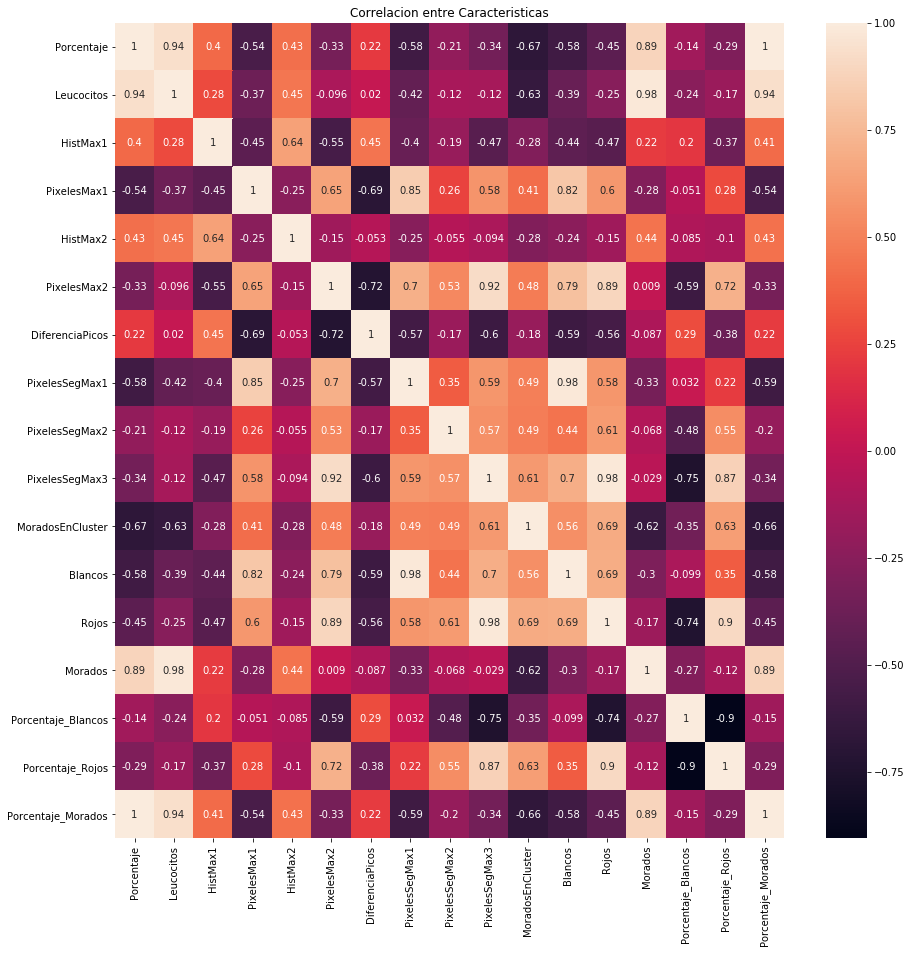



//// Porcentaje ////
Porcentaje            1.000000
Leucocitos            0.937619
PixelesMax1           0.537287
PixelesSegMax1        0.583670
MoradosEnCluster      0.666817
Blancos               0.578599
Morados               0.887452
Porcentaje_Morados    0.999786
Name: Porcentaje, dtype: float64


//// Leucocitos ////
Porcentaje            0.937619
Leucocitos            1.000000
MoradosEnCluster      0.631788
Morados               0.980209
Porcentaje_Morados    0.936716
Name: Leucocitos, dtype: float64


//// HistMax1 ////
HistMax1       1.000000
HistMax2       0.642742
PixelesMax2    0.553374
Name: HistMax1, dtype: float64


//// PixelesMax1 ////
Porcentaje            0.537287
PixelesMax1           1.000000
PixelesMax2           0.647239
DiferenciaPicos       0.693581
PixelesSegMax1        0.850594
PixelesSegMax3        0.582193
Blancos               0.816313
Rojos                 0.597282
Porcentaje_Morados    0.539026
Name: PixelesMax1, dtype: float64


//// HistMax2 ////
His

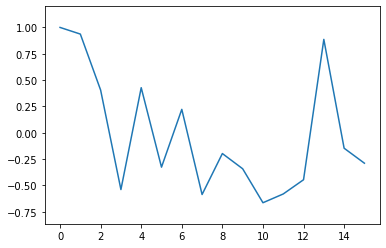

Elapsed time: 1.3047421000 seconds.


In [11]:
start_time = timeit.default_timer()

# Matriz de Correlaciones
X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')
# Creamos el dataframe con nuestros datos 
X_norm_std = normalizarDatos(X)
df = pd.DataFrame(X_norm_std, columns = feature_names)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7)

correlation_mat = df.corr()
print(correlation_mat)

fig, ax = plt.subplots(figsize=(15,15)) 
plt.title("Correlacion entre Caracteristicas")
sns.heatmap(correlation_mat, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/' + 'Importancia de las 17 Caracteristicas 8')
plt.show()

for i in range(len(feature_names)):
    cor_target = abs(correlation_mat[feature_names[i]])
    relevant_features = cor_target[cor_target>0.5]
    print('\n')
    print('////',feature_names[i],'////')
    print(relevant_features)

# nos quedamos con la última columna del DataFrame 
# (todas las filas de correlaciones menos la última porque es la correlación de la variable a predecir consigo misma)
correlacionConClase = correlation_mat.iloc[:-1,-1]

# Mostramos el valor de correlación mínimo y máximo
maximo = correlacionConClase.max()
minimo = correlacionConClase.min()
print ("El maximo es " + str(maximo))
print ("El minimo es " + str(minimo))

nombre = range(16)

# Mostramos una figura que muestre la correlación entre las variables de entrada y de salida
plt.plot(nombre, correlacionConClase)
plt.ylim(minimo - 0.2, maximo + 0.2)
plt.show()

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

#### Tal y como hemos podido observar, hay hiper parametros que comparten una gran correlacion, por lo que la informacion que nos pueden dar, sera similar. Vamos a eliminar del dataset uno de los hiper parametros de cada pareja que compartan una correlacion mayor al 80%

In [15]:
start_time = timeit.default_timer()

# Generamos un DataFrame solamente con los datos de entrada (X_train): sin la salida
datos = pd.DataFrame(X_train)

# Creamos la matriz de correlación en valor absoluto: función abs (da igual se se correlacionan positiva o negativamente)
corr_matrix = datos.corr()

# Seleccionamos el triángulo superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Umbral deseado para determinar variables correlacionadas
umbral = 0.8

# Obtenemos los índices de aquellas variables con correlación mayor al umbral deseado
variables_a_eliminar = [column for column in upper.columns if any(upper[column] > umbral)]
print('Variables a eliminar: ', variables_a_eliminar)

# Eliminamos las variables con alta correlación con alguna de las variables de entrada 
datos = datos.drop(datos.columns[variables_a_eliminar], axis=1)

# Realizamos la selección de variables para el conjunto de test
datosTest = pd.DataFrame(X_test)

datosTest = datosTest.drop(datosTest.columns[variables_a_eliminar], axis=1)

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

Variables a eliminar:  [1, 7, 9, 11, 12, 13, 15, 16]
Elapsed time: 0.0134721000 seconds.


#### Tenemos 8 variables altamente correlacionadas, por lo que no nos van a aportar informacion extra. Asi pues, las eliminamos e intentamos ver si obtenemos mejores resultados sin ellas

In [16]:
start_time = timeit.default_timer()

print('Vamos a eliminar las variables:',variables_a_eliminar)
numeros = np.arange(caracteristicas)
numeros = np.delete(numeros, variables_a_eliminar, axis = None)

X, y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')

X_2 = X[:,numeros]
resultados_aprendizaje_normalizado(X_2,y,grid=True,verbose=True)

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

Vamos a eliminar las variables: [1, 7, 9, 11, 12, 13, 15, 16]
1- Metodo de normalizacion: Sin normalizar

     -Clasificador: KNeighborsClassifier 

      knn {'n_neighbors': 3, 'p': 1.5, 'weights': 'uniform'} 90.72727272727275%


     -Clasificador: DecisionTreeClassifier 

      arbol_decision {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2} 98.18181818181819%


     -Clasificador: RandomForestClassifier 

      random_forest {'criterion': 'gini', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 10} 100.0%


     -Clasificador: LogisticRegression 

      logistica {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'} 90.45454545454547%


     -Clasificador: SVC 

      svm {'C': 100, 'gamma': 'scale'} 86.0%


     -Clasificador: MLPClassifier 

      red_neuronal {'activation': 'tanh', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'shuffle': False, 'solver': 'lbfgs'} 82.45454545454545%

2- Metodo de normalizacion: MinMaxScaler()

    

#### Podemos observar como tras eliminar 8 de las variables con mayor correlacion, obtenemos tambien unos muy buenos resultados. Sin embargo, no llegan a ser tan buenos como los anteriores

#### Si nos fijamos, tras aplicar un random forest con el conjunto de hiper parametros obtenidos tras la reduccion, llegamos a un 100% tanto en train como en test, por lo que llegamos ya a unos resultados inmejorbles en cuanto a porcentajes

In [22]:
start_time = timeit.default_timer()

X_2 =  NormalizarDatosStandard(X_2)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_2, y, train_size=0.7, random_state = 123)

# Creamos el modelo con los mejores resultados
modelo = ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10)
# Lo entrenamos
modelo.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos de entrenamiento (tras reducir su dimensionalidad)
prediccionTrain =  modelo.predict(X_train)

# Llamada a la función que calcula el porcentaje de acierto para los datos de entrenamiento 
accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100

print('El rendimiento en entrenamiento con las variables seleccionadas mediante correlación es el {}%'.format(accTrain))

# Llamada a la función que realiza la predicción de los datos de test (tras reducir su dimensionalidad)
prediccionTest =  modelo.predict(X_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos de test
accTest =  metrics.accuracy_score(y_test, prediccionTest)*100

print('El rendimiento en test con las variables seleccionadas mediante correlación es el {}%'.format(accTest))

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

El rendimiento en entrenamiento con las variables seleccionadas mediante correlación es el 100.0%
El rendimiento en test con las variables seleccionadas mediante correlación es el 100.0%
Elapsed time: 0.0099985000 seconds.


#### Ahora que ya tenemos nuestro modelo, vamos a intentar ver la importancia que tiene cada uno de los 17 hiper parametros en la clasificacion

Accuracy on test data: 1.00


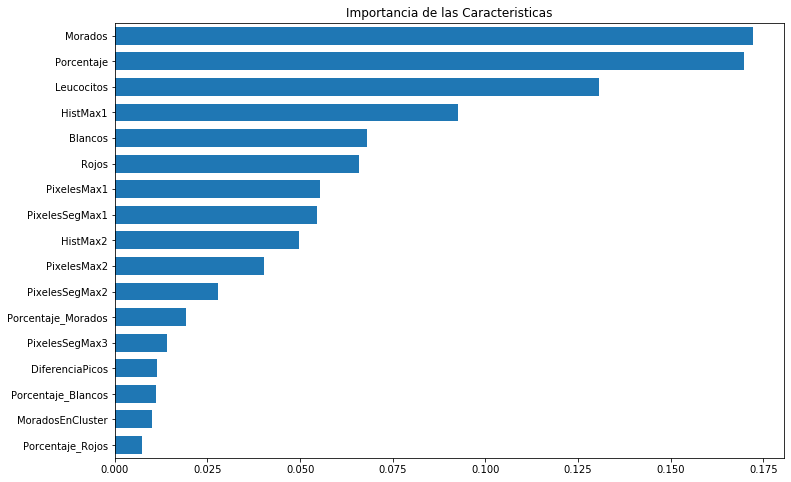

Elapsed time: 0.3606510000 seconds.


In [24]:
start_time = timeit.default_timer()

X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')

feature_names_sorted_by_tree = []
X_norm_std = normalizarDatos(X)

# Separamos en Train y Test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7, random_state = 10)

RF =  ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 10, max_features = 1, min_samples_split = 2, n_estimators = 10)
RF.fit(X_train,y_train)
print("Accuracy on test data: {:.2f}".format(RF.score(X_test, y_test)))

result = permutation_importance(RF, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(RF.feature_importances_)
tree_indices = np.arange(0, len(RF.feature_importances_)) + 0.5

for i in range(caracteristicas):
    feature_names_sorted_by_tree.append(feature_names[tree_importance_sorted_idx[i]])
    
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
plt.title("Importancia de las Caracteristicas")
ax1.barh(tree_indices,
         RF.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names_sorted_by_tree)
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(RF.feature_importances_)))
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/' + 'Importancia de las 5 Caracteristicas 1')
plt.show()

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

Ranking de importancias por Caracteristica:
     1 - Caracteristica MoradosEnCluster : 0.1336
     2 - Caracteristica Blancos : 0.1064
     3 - Caracteristica Leucocitos : 0.0975
     4 - Caracteristica Morados : 0.0898
     5 - Caracteristica PixelesSegMax3 : 0.0795
     6 - Caracteristica PixelesSegMax1 : 0.0783
     7 - Caracteristica Porcentaje : 0.0726
     8 - Caracteristica HistMax2 : 0.0611
     9 - Caracteristica PixelesMax1 : 0.0608
     10 - Caracteristica PixelesMax2 : 0.0574
     11 - Caracteristica Porcentaje_Blancos : 0.0533
     12 - Caracteristica Porcentaje_Morados : 0.0417
     13 - Caracteristica PixelesSegMax2 : 0.0261
     14 - Caracteristica DiferenciaPicos : 0.0162
     15 - Caracteristica Porcentaje_Rojos : 0.0105
     16 - Caracteristica Rojos : 0.0101
     17 - Caracteristica HistMax1 : 0.0049


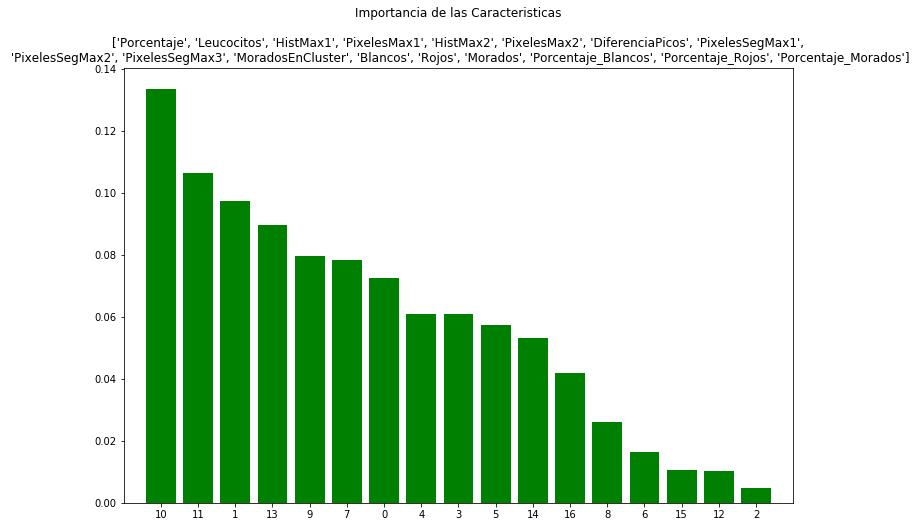

Elapsed time: 0.2416642000 seconds.


In [26]:
start_time = timeit.default_timer()

feature_names_sorted = []

X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')
X_norm_std = normalizarDatos(X)

# Separamos en Train y Test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7)

# Build a forest and compute the impurity-based feature importances
RF =  ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10,random_state = 10)
RF.fit(X_train,y_train)
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Ranking de importancias por Caracteristica:")

for f in range(X.shape[1]):
    print("    ",f + 1, "- Caracteristica",feature_names[indices[f]],":",round(importances[indices[f]], 4))
    
for i in range(17):
    feature_names_sorted.append(feature_names[indices[i]])

# Plot the impurity-based feature importances of the forest
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
plt.title("Importancia de las Caracteristicas\n\n['Porcentaje', 'Leucocitos', 'HistMax1', 'PixelesMax1', 'HistMax2', 'PixelesMax2', 'DiferenciaPicos', 'PixelesSegMax1',\n 'PixelesSegMax2', 'PixelesSegMax3', 'MoradosEnCluster', 'Blancos', 'Rojos', 'Morados', 'Porcentaje_Blancos', 'Porcentaje_Rojos', 'Porcentaje_Morados']")
plt.bar(range(X.shape[1]), importances[indices], color= 'g')
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/' + 'Importancia de las 5 Caracteristicas 2')
plt.show()

elapsed = timeit.default_timer() - start_time
print("Elapsed time: %.10f seconds." % elapsed)

In [33]:
# Normalizamos los datos
X_norm_std = normalizarDatos(X)

# Separamos en Train y Test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7, random_state = 10)

# Creamos el modelo
RF =  ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10)

# Entrenamos
RF.fit(X_train, y_train)

# Calculamos las predicciones
prediccionTrain = RF.predict(X_train_seleccion)
prediccionTest =  RF.predict(X_test_seleccion)

# Sacamos la Precision, Recall y FScore
accTest = metrics.accuracy_score(prediccionTest,y_test)
recall = metrics.recall_score(prediccionTest,y_test)
fScore = 2 * (accTest * recall) / (accTest + recall) 

# METODO DE INTERPRETABILIDAD: ELI5
perm = PermutationImportance(RF, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = feature_names)


Weight,Feature
0.0242 ± 0.0242,Porcentaje
0.0242 ± 0.0242,Leucocitos
0.0182 ± 0.0297,Porcentaje_Morados
0.0061 ± 0.0242,Blancos
0.0061 ± 0.0242,HistMax2
0 ± 0.0000,Morados
0 ± 0.0000,Rojos
0 ± 0.0000,MoradosEnCluster
0 ± 0.0000,PixelesSegMax3
0 ± 0.0000,Porcentaje_Rojos


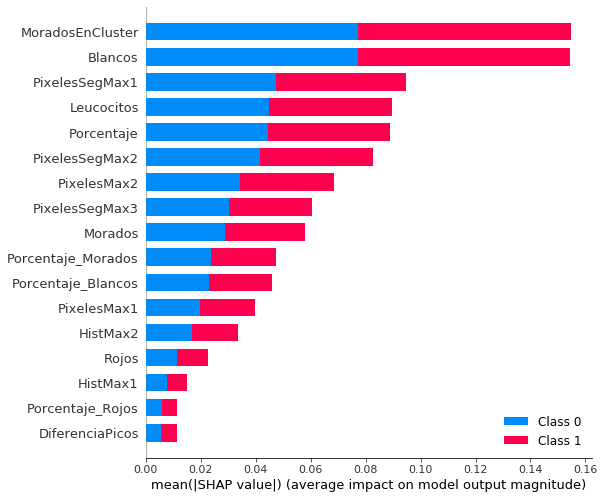

In [34]:
# METODO DE INTERPRETABILIDAD: SHAP VALUES

X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')
X_norm_std = normalizarDatos(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7)
# Build a forest and compute the impurity-based feature importances
RF =  ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10,random_state = 10)
RF.fit(X_train,y_train)

shap_abs_sums = []
shap_diff = []
shap_values = shap.TreeExplainer(RF).shap_values(X_norm_std)
shap.summary_plot(shap_values, X_norm_std, feature_names)

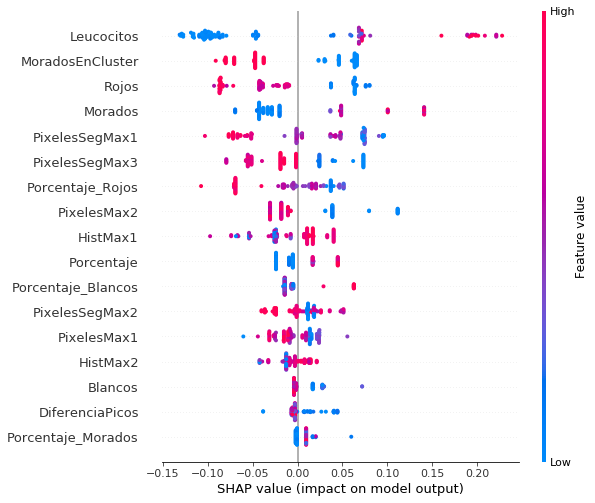

In [35]:
# METODO DE INTERPRETABILIDAD: SHAP VALUES
X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')
X_norm_std = normalizarDatos(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7)
# Build a forest and compute the impurity-based feature importances
RF =  ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10,random_state = 10)
RF.fit(X_train,y_train)

RF = RandomForestRegressor(max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10).fit(X_norm_std, y)
shap_values = shap.TreeExplainer(RF).shap_values(X_norm_std)
shap.summary_plot(shap_values, X_norm_std, feature_names)
shap_abs_sums.append(np.abs(shap_values).sum(0))
shap_diff.append(shap_values.max(0) - shap_values.min(0))

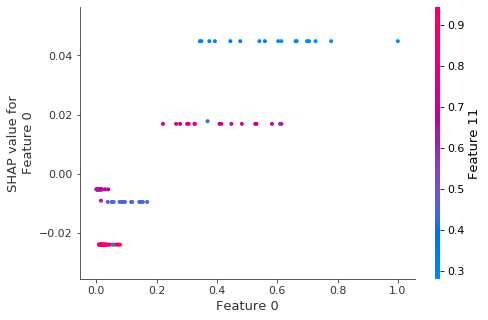

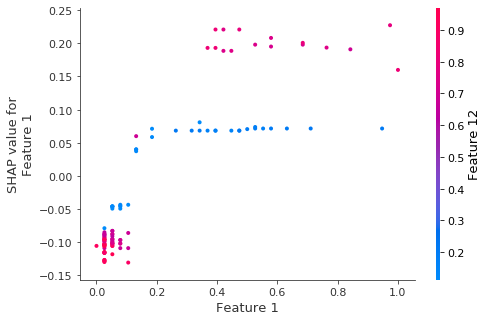

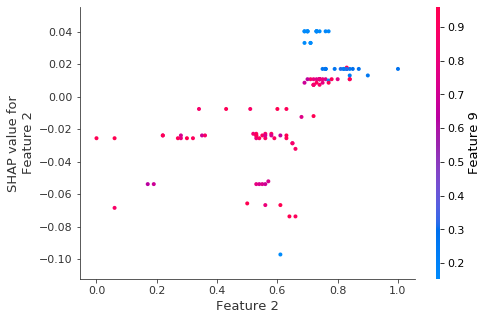

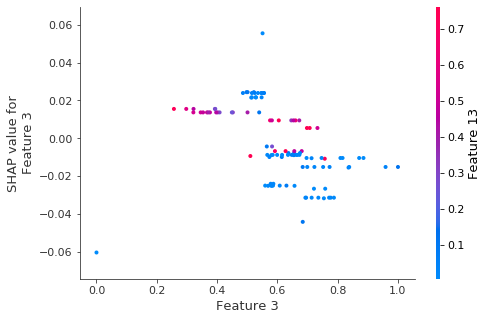

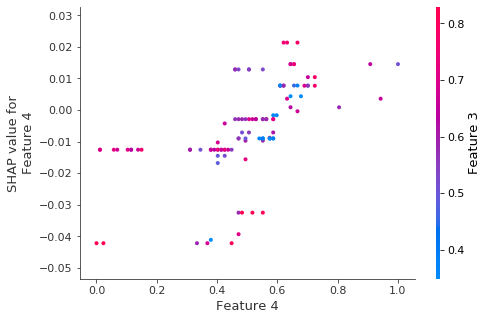

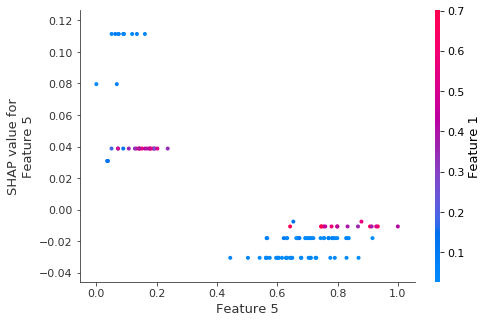

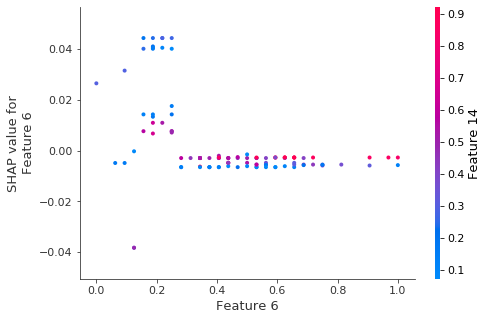

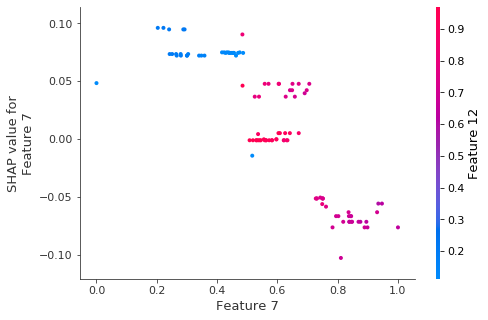

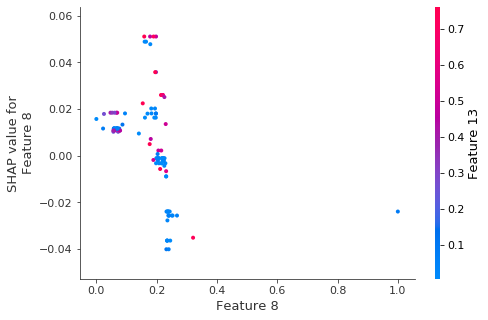

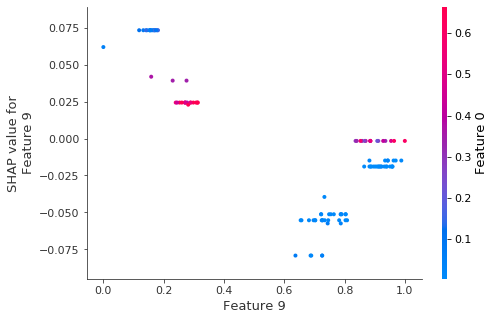

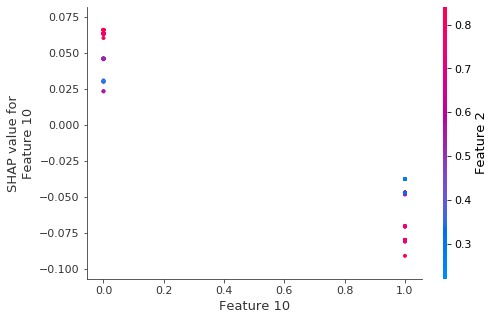

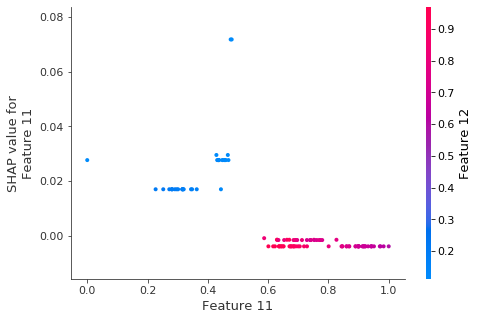

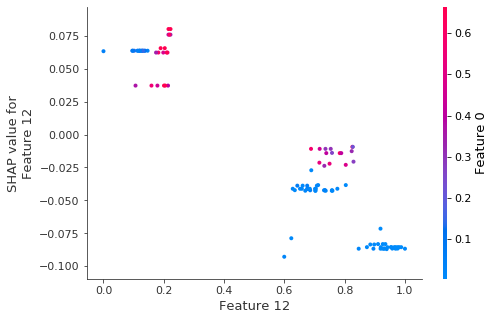

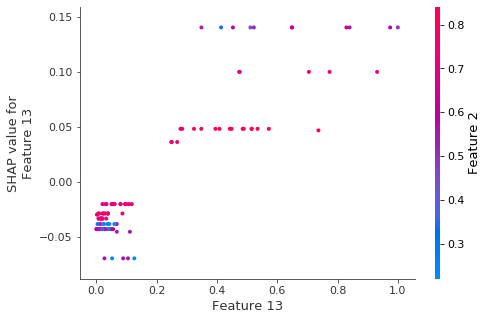

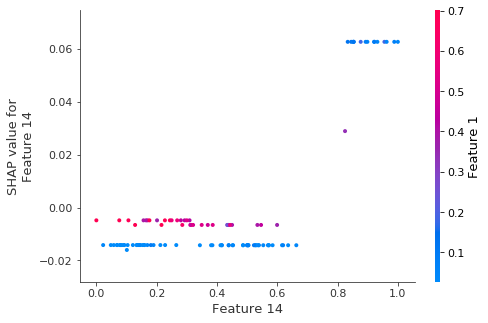

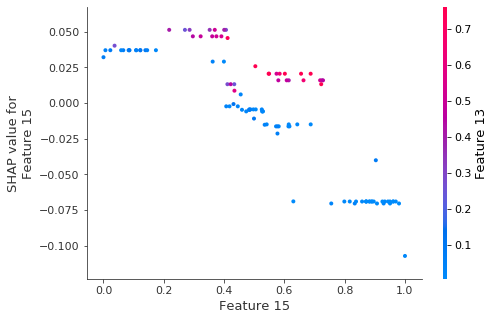

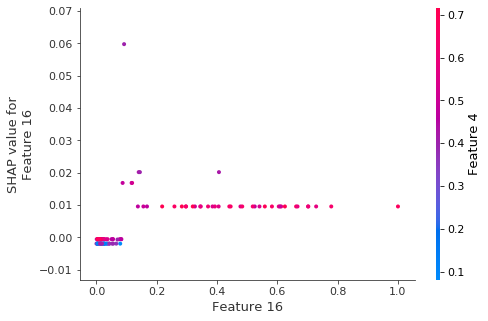

In [38]:
# METODO DE INTERPRETABILIDAD: SHAP VALUES
X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')
X_norm_std = normalizarDatos(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7)
# Build a forest and compute the impurity-based feature importances
RF =  ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10,random_state = 10)
RF.fit(X_train,y_train)

# Creamos un grafico que muestre la influencia de cada parametro en el dataset
for i in range(17):
    shap.dependence_plot(i, shap_values, X_norm_std, show=False)
    plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/' + 'Importancia de las 17 Caracteristicas 6 - '+ feature_names[i])
    


In [37]:
# Normalizamos los datos
X_norm_std = normalizarDatos(X)

# Separamos en Train y Test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7, random_state = 10)

# Entrenamos a nuestro modelo seleccionado con sus parametros
tecnicaSeleccion = feature_selection.RFE(ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10), n_features_to_select=14, step=1)
tecnicaSeleccion.fit(X_train, y_train)
X_train_seleccion = tecnicaSeleccion.transform(X_train)
X_test_seleccion =  tecnicaSeleccion.transform(X_test)
RF =  ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 10)
RF.fit(X_train_seleccion,y_train)

# Calculamos la prediccion una vez entrenado
prediccionTrain = RF.predict(X_train_seleccion)
prediccionTest =  RF.predict(X_test_seleccion)

# Sacamos la Precision, Recall y FScore
accTest = metrics.accuracy_score(prediccionTest,y_test)
recall = metrics.recall_score(prediccionTest,y_test)
fScore = 2 * (accTest * recall) / (accTest + recall) 

print("El Random Forest con precisión {}, nos da un recall de {} y un FScore de {}".format(accTest,recall,fScore))

# Plot de los Arboles del Random Forest
with open(RUTA_PRUEBA + '/data_tfg.csv', "r") as f:
    reader = csv.reader(f)
    feature_names = next(reader)
    
fn = feature_names
cn = ['Sano','Leucemia']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (10,10), dpi=1000)

for index in range(0, 10):
    tree.plot_tree(RF.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True);
    fig.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/' + 'Importancia de las 5 Caracteristicas 7 - Arbol Num.'  + str(index + 1) + '.png')

El Random Forest con precisión 1.0, nos da un recall de 1.0 y un FScore de 1.0


#### Analizamos los resultados para cada clasificador normalizado

In [39]:
## OBTENEMOS LOS DATOS

# Leemos los datos
X,y = leerDatos(RUTA_PRUEBA + '/data_tfg.csv')
X_norm_std = normalizarDatos(X)

# Separamos en Train y Test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_norm_std, y, train_size=0.7, random_state = 10)

### 1 - Redes Neuronales

Para las Redes Neuronales, con los mejores parametros, obtenemos los siguientes resultados:
-Accuracy en Train: 100.0
-Accuracy en Test: 100.0
-Recall: 100.0
-Fscore: 100.0
-Precision: 1.0
-Precision_Media: 1.0


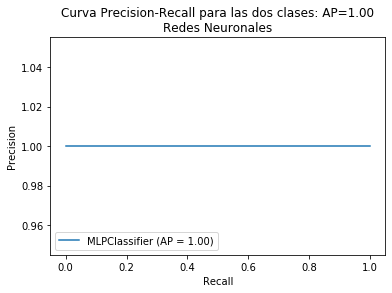

In [202]:
# Creamos el modelo con los mejores resultados
modelo = neural_network.MLPClassifier(activation = 'identity', hidden_layer_sizes = 10, learning_rate = 'constant', shuffle = True, solver = 'lbfgs')

# Lo entrenamos
modelo.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos (tras reducir su dimensionalidad)
prediccionTrain =  modelo.predict(X_train)
prediccionTest =  modelo.predict(X_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos 
accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionTest)*100
recall = metrics.recall_score(prediccionTest,y_test)*100
F1 = 2 * (accTest * recall) / (accTest + recall)
precision = precision_score(y_test, prediccionTest)
precision_media = average_precision_score(y_test, prediccionTest)

print('Para las Redes Neuronales, con los mejores parametros, obtenemos los siguientes resultados:')
print('-Accuracy en Train:',accTrain)
print('-Accuracy en Test:',accTest)
print('-Recall:',recall)
print('-Fscore:',F1)
print('-Precision:',precision)
print('-Precision_Media:',precision_media)

disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title('Curva Precision-Recall para las dos clases: '
                   'AP={0:0.2f}\nRedes Neuronales'.format(precision_media))
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/Redes Neuronales.png')
plt.show()

### 2 - Arboles de Decision

Para los Arboles de Decision, con los mejores parametros, obtenemos los siguientes resultados:
-Accuracy en Train: 100.0
-Accuracy en Test: 100.0
-Recall: 100.0
-Fscore: 100.0
-Precision: 1.0
-Precision_Media: 1.0


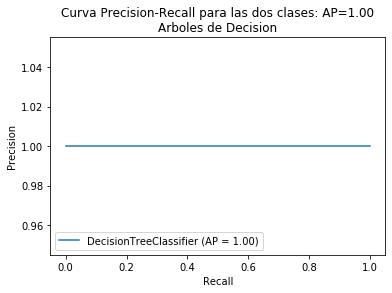

In [182]:
# Creamos el modelo con los mejores resultados
modelo = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 1, min_samples_split = 2)

# Lo entrenamos
modelo.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos (tras reducir su dimensionalidad)
prediccionTrain =  modelo.predict(X_train)
prediccionTest =  modelo.predict(X_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos 
accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionTest)*100
recall = metrics.recall_score(prediccionTest,y_test)*100
F1 = 2 * (accTest * recall) / (accTest + recall)
precision = precision_score(y_test, prediccionTest)
precision_media = average_precision_score(y_test, prediccionTest)

print('Para los Arboles de Decision, con los mejores parametros, obtenemos los siguientes resultados:')
print('-Accuracy en Train:',accTrain)
print('-Accuracy en Test:',accTest)
print('-Recall:',recall)
print('-Fscore:',F1)
print('-Precision:',precision)
print('-Precision_Media:',precision_media)

disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title('Curva Precision-Recall para las dos clases: '
                   'AP={0:0.2f}\nArboles de Decision'.format(precision_media))
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/Arboles de Decision.png')
plt.show()

### 3 - KNN

Para el KNN, con los mejores parametros, obtenemos los siguientes resultados:
-Accuracy en Train: 100.0
-Accuracy en Test: 100.0
-Recall: 100.0
-Fscore: 100.0
-Precision: 1.0
-Precision_Media: 1.0


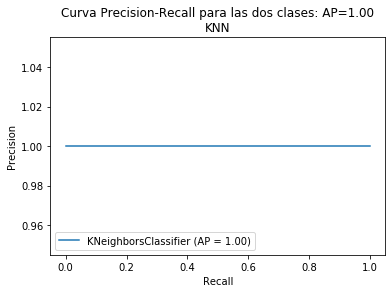

In [183]:
# Creamos el modelo con los mejores resultados
modelo = neighbors.KNeighborsClassifier(n_neighbors = 2, p = 1, weights = 'uniform')

# Lo entrenamos
modelo.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos (tras reducir su dimensionalidad)
prediccionTrain =  modelo.predict(X_train)
prediccionTest =  modelo.predict(X_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos 
accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionTest)*100
recall = metrics.recall_score(prediccionTest,y_test)*100
F1 = 2 * (accTest * recall) / (accTest + recall)
precision = precision_score(y_test, prediccionTest)
precision_media = average_precision_score(y_test, prediccionTest)

print('Para el KNN, con los mejores parametros, obtenemos los siguientes resultados:')
print('-Accuracy en Train:',accTrain)
print('-Accuracy en Test:',accTest)
print('-Recall:',recall)
print('-Fscore:',F1)
print('-Precision:',precision)
print('-Precision_Media:',precision_media)

disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title('Curva Precision-Recall para las dos clases: '
                   'AP={0:0.2f}\nKNN'.format(precision_media))
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/KNN.png')
plt.show()

### 4 - Random Forest

Para los Random Forest, con los mejores parametros, obtenemos los siguientes resultados:
-Accuracy en Train: 100.0
-Accuracy en Test: 100.0
-Recall: 100.0
-Fscore: 100.0
-Precision: 1.0
-Precision_Media: 1.0


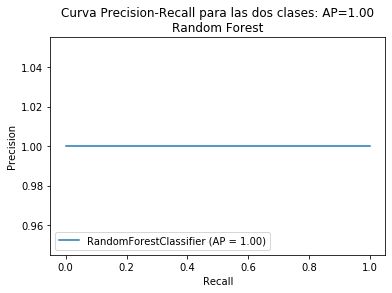

In [184]:
# Creamos el modelo con los mejores resultados
modelo = ensemble.RandomForestClassifier(criterion = 'gini', max_depth = 5, max_features = 1, min_samples_split = 2, n_estimators = 2)

# Lo entrenamos
modelo.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos (tras reducir su dimensionalidad)
prediccionTrain =  modelo.predict(X_train)
prediccionTest =  modelo.predict(X_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos 
accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionTest)*100
recall = metrics.recall_score(prediccionTest,y_test)*100
F1 = 2 * (accTest * recall) / (accTest + recall)
precision = precision_score(y_test, prediccionTest)
precision_media = average_precision_score(y_test, prediccionTest)

print('Para los Random Forest, con los mejores parametros, obtenemos los siguientes resultados:')
print('-Accuracy en Train:',accTrain)
print('-Accuracy en Test:',accTest)
print('-Recall:',recall)
print('-Fscore:',F1)
print('-Precision:',precision)
print('-Precision_Media:',precision_media)

disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title('Curva Precision-Recall para las dos clases: '
                   'AP={0:0.2f}\nRandom Forest'.format(precision_media))
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/Random Forest.png')
plt.show()

### 5 - Regresion Logistica

Para la Regresion Logistica, con los mejores parametros, obtenemos los siguientes resultados:
-Accuracy en Train: 98.66666666666667
-Accuracy en Test: 100.0
-Recall: 100.0
-Fscore: 100.0
-Precision: 1.0
-Precision_Media: 1.0


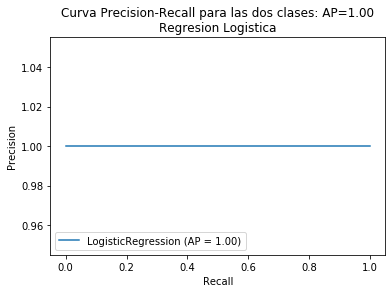

In [185]:
# Creamos el modelo con los mejores resultados
modelo = linear_model.LogisticRegression(C = 10, penalty = 'l2', solver = 'lbfgs')

# Lo entrenamos
modelo.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos (tras reducir su dimensionalidad)
prediccionTrain =  modelo.predict(X_train)
prediccionTest =  modelo.predict(X_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos 
accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionTest)*100
recall = metrics.recall_score(prediccionTest,y_test)*100
F1 = 2 * (accTest * recall) / (accTest + recall)
precision = precision_score(y_test, prediccionTest)
precision_media = average_precision_score(y_test, prediccionTest)

print('Para la Regresion Logistica, con los mejores parametros, obtenemos los siguientes resultados:')
print('-Accuracy en Train:',accTrain)
print('-Accuracy en Test:',accTest)
print('-Recall:',recall)
print('-Fscore:',F1)
print('-Precision:',precision)
print('-Precision_Media:',precision_media)

disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title('Curva Precision-Recall para las dos clases: '
                   'AP={0:0.2f}\nRegresion Logistica'.format(precision_media))
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/Regresion Logistica.png')
plt.show()

### 6 - SVM

Para el SVM, con los mejores parametros, obtenemos los siguientes resultados:
-Accuracy en Train: 86.66666666666667
-Accuracy en Test: 84.84848484848484
-Recall: 100.0
-Fscore: 91.80327868852459
-Precision: 1.0
-Precision_Media: 0.7348484848484849


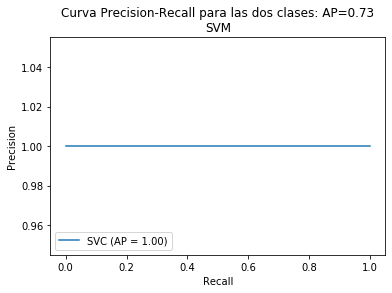

In [186]:
# Creamos el modelo con los mejores resultados
modelo = svm.SVC(C = 0.03, gamma = 3)

# Lo entrenamos
modelo.fit(X_train,y_train)

# Llamada a la función que realiza la predicción de los datos (tras reducir su dimensionalidad)
prediccionTrain =  modelo.predict(X_train)
prediccionTest =  modelo.predict(X_test)

# Llamada a la función que calcula el porcentaje de acierto para los datos 
accTrain =  metrics.accuracy_score(y_train,prediccionTrain)*100
accTest =  metrics.accuracy_score(y_test,prediccionTest)*100
recall = metrics.recall_score(prediccionTest,y_test)*100
F1 = 2 * (accTest * recall) / (accTest + recall)
precision = precision_score(y_test, prediccionTest)
precision_media = average_precision_score(y_test, prediccionTest)

print('Para el SVM, con los mejores parametros, obtenemos los siguientes resultados:')
print('-Accuracy en Train:',accTrain)
print('-Accuracy en Test:',accTest)
print('-Recall:',recall)
print('-Fscore:',F1)
print('-Precision:',precision)
print('-Precision_Media:',precision_media)

disp = plot_precision_recall_curve(modelo, X_test, y_test)
disp.ax_.set_title('Curva Precision-Recall para las dos clases: '
                   'AP={0:0.2f}\nSVM'.format(precision_media))
plt.savefig(RUTA_PRUEBA + 'Imagenes Interpretabilidad/SVM.png')
plt.show()

In [40]:
shutil.copy(RUTA_CODE, RUTA_PRUEBA + PRUEBA +  '_' + RUTA_CODE)

'Imagenes_Resultados/12-1-2021/Prueba 1/Prueba 1_TFG.ipynb'